In [1]:
# original gan architectures and training codes from https://github.com/lyeoni/pytorch-mnist-GAN

# prerequisites
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

# Library that computes FID.
!pip install pytorch-fid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seed for reproducibility

seed = 0

torch.manual_seed(seed)

In [2]:
# TODO include link to implementation

# Lookahead optimizer
from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer


class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(param_state['cached_params'], alpha=1.0 - self.la_alpha)  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [3]:
checkpoint_path = './checkpoints/'

In [4]:
# batch size.
bs = 100

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Define networks

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, self.fc3.out_features)
        self.fc5 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.leaky_relu(self.fc4(x), 0.2)
        return torch.tanh(self.fc5(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [6]:
lrs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [7]:
# loss fuction
criterion = nn.BCELoss() 

# learning rate
lr = 0.00001 # 0.0001 for adam mnist, 0.001 for SGD both dataset

# number of epochs every number is trained for
n_epoch = 200

# size of the set of pictures generated for FID computation
G_set_size = 10000

# dimension of the generation seeds
z_dim = 100

optimizers = []
optimizers.append('Adam')
optimizers.append('Lookahead Adam')
optimizers.append('SGD')
optimizers.append('Lookahead SGD')

In [8]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    D_batch_real_acc = len(d[d==1])/len(y_real)

    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    D_batch_fake_acc = len(d[d==0])/len(y_fake)

    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item(), D_batch_real_acc, D_batch_fake_acc

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    # How many times G tricks D. (Hope it's correct?)
    G_batch_acc = len(d[d==1])/len(y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(), G_batch_acc

# MNIST

### Load data

In [10]:
dataset_name = 'MNIST'

# load MNIST data
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Save pictures from test dataset to computer FID later
count = 0
for i, batch in enumerate(test_loader):
    for b in range(len(batch[0])):
        save_image(batch[0][b], './FID_data/test_pictures/img' + str(count) + '.png')
        count += 1
    print('Saving test pictures : {}/{}...'.format(count, len(test_loader)*bs), end='\r')

In [11]:
# save first batch as a picture
save_image(next(iter(train_loader))[0], './{}_batch1'.format(dataset_name) + '.png')

In [12]:
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

# define generator and discriminator
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

### Train and evaluate networks

In [13]:
###### https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

FIDs_dic = {}

for opt_name in optimizers:
    print('Training using ' + opt_name)

    G_loss_per_epoch = []
    D_loss_per_epoch = []
    
    D_real_acc_per_epoch = []
    D_fake_acc_per_epoch = []
    G_acc_per_epoch = []
    
    FIDs = []
    list_epochs = []

    G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
    D = Discriminator(mnist_dim).to(device)
    
    if opt_name == 'Adam':
        lr = 0.0001
        G_optimizer = optim.Adam(G.parameters(), lr = lr)
        D_optimizer = optim.Adam(D.parameters(), lr = lr)
    elif opt_name == 'Lookahead Adam':
        lr = 0.0001
        G_optimizer = optim.Adam(G.parameters(), lr = lr)
        G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
        D_optimizer = optim.Adam(D.parameters(), lr = lr)
        D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
    elif opt_name == 'SGD':
        lr = 0.001
        G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
        D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
    elif opt_name == 'Lookahead SGD':
        lr = 0.001
        G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
        G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
        D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
        D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
    
    for epoch in range(1, n_epoch+1):
        D_losses, G_losses = [], []
        D_real_accs, D_fake_accs, G_accs = [], [], []
        
        for batch_idx, (x, _) in enumerate(train_loader):
            D_current_loss, D_batch_real_acc, D_batch_fake_acc = D_train(x)
            G_current_loss, G_batch_acc = G_train(x)
    
            D_real_accs.append(D_batch_real_acc)
            D_fake_accs.append(D_batch_fake_acc)
            G_accs.append(G_batch_acc)
    
            D_losses.append(D_current_loss)
            G_losses.append(G_current_loss)
    
        G_loss = torch.mean(torch.FloatTensor(G_losses))
        D_loss = torch.mean(torch.FloatTensor(D_losses))
    
        G_loss_per_epoch.append(G_loss.item())
        D_loss_per_epoch.append(D_loss.item())
    
        D_real_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_real_accs)).item())
        D_fake_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_fake_accs)).item())
        G_acc_per_epoch.append(torch.mean(torch.FloatTensor(G_accs)).item())
        
        print('[%d/%d]: loss_d: %.7f, loss_g: %.3f' % ((epoch), n_epoch, D_loss, G_loss)) 
        
        count = 0
        if epoch == 1 or epoch%20 == 0 or epoch == n_epoch: # every n epochs and after last epoch

            # save pictures generated with generator and compute current FID
            for i in range(int(G_set_size/bs)):
                G_seeds = torch.randn(bs, z_dim).to(device)
                G_pictures = G(G_seeds)
                G_pictures = G_pictures.view(G_pictures.size(0), 1, 28, 28)
    
                for b in range(bs):
                    save_image(G_pictures[b], './FID_data/generated_pictures/img' + str(count) + '.png')
                    count += 1
                print('Generating pictures : {}/{}...'.format(count, G_set_size), end='\r')
            print()
            print('Computing FID...', end='\r')
            fid = !python -m pytorch_fid "./FID_data/generated_pictures/" "./FID_data/test_pictures/"
            fid = float(fid[-1].replace('FID:  ', ''))
            print('FID : {}'.format(fid), end='\r')
            print()
            FIDs.append(fid) 
            list_epochs.append(epoch)
            
            # generate and save samples
            samples_per_epoch = 1
            for sample_nbr in range(1, samples_per_epoch+1):
                with torch.no_grad():
                    test_z = torch.randn(bs, z_dim).to(device)
                    generated = G(test_z)
                    save_image(generated.view(generated.size(0), 1, 28, 28), './{}_{}_epoch_{}'.format(dataset_name, opt_name, epoch) + '.png')
    
    FIDs_dic[opt_name] = FIDs

Training using Adam
[1/200]: loss_d: 1.2095982, loss_g: 1.053
Generating pictures : 10000/10000...
FID : 242.33152997938177
[2/200]: loss_d: 1.2787131, loss_g: 0.902
[3/200]: loss_d: 0.3727446, loss_g: 6.474
[4/200]: loss_d: 0.0010250, loss_g: 12.894
[5/200]: loss_d: 0.0026603, loss_g: 13.350
[6/200]: loss_d: 0.0004528, loss_g: 13.689
[7/200]: loss_d: 0.0000894, loss_g: 16.413
[8/200]: loss_d: 0.0000354, loss_g: 17.282
[9/200]: loss_d: 0.0000251, loss_g: 17.674
[10/200]: loss_d: 0.0032395, loss_g: 14.389
[11/200]: loss_d: 0.0000571, loss_g: 17.377
[12/200]: loss_d: 0.0000216, loss_g: 19.100
[13/200]: loss_d: 0.0000221, loss_g: 22.561
[14/200]: loss_d: 0.0000052, loss_g: 21.246
[15/200]: loss_d: 0.0000034, loss_g: 21.585
[16/200]: loss_d: 0.0000025, loss_g: 21.731
[17/200]: loss_d: 0.0000019, loss_g: 22.719
[18/200]: loss_d: 0.0000013, loss_g: 23.433
[19/200]: loss_d: 0.0000009, loss_g: 23.729
[20/200]: loss_d: 0.0000006, loss_g: 24.091
Generating pictures : 10000/10000...
FID : 388.779

[173/200]: loss_d: 0.0000000, loss_g: 57.832
[174/200]: loss_d: 0.0000000, loss_g: 57.825
[175/200]: loss_d: 0.0000000, loss_g: 57.796
[176/200]: loss_d: 0.0000000, loss_g: 57.815
[177/200]: loss_d: 0.0000000, loss_g: 57.761
[178/200]: loss_d: 0.0000000, loss_g: 57.756
[179/200]: loss_d: 0.0000000, loss_g: 57.840
[180/200]: loss_d: 0.0000000, loss_g: 57.740
Generating pictures : 10000/10000...
FID : 366.5260939586253
[181/200]: loss_d: 0.0000000, loss_g: 57.723
[182/200]: loss_d: 0.0000000, loss_g: 57.772
[183/200]: loss_d: 0.0000000, loss_g: 57.767
[184/200]: loss_d: 0.0000000, loss_g: 57.708
[185/200]: loss_d: 0.0000000, loss_g: 57.621
[186/200]: loss_d: 0.0000000, loss_g: 57.641
[187/200]: loss_d: 0.0000000, loss_g: 57.613
[188/200]: loss_d: 0.0000000, loss_g: 57.523
[189/200]: loss_d: 0.0000000, loss_g: 57.573
[190/200]: loss_d: 0.0000000, loss_g: 57.655
[191/200]: loss_d: 0.0000000, loss_g: 57.615
[192/200]: loss_d: 0.0000000, loss_g: 57.652
[193/200]: loss_d: 0.0000000, loss_g: 5

[147/200]: loss_d: 1.2981046, loss_g: 0.844
[148/200]: loss_d: 1.2979320, loss_g: 0.843
[149/200]: loss_d: 1.2990563, loss_g: 0.838
[150/200]: loss_d: 1.3016626, loss_g: 0.838
[151/200]: loss_d: 1.2998238, loss_g: 0.839
[152/200]: loss_d: 1.3071880, loss_g: 0.828
[153/200]: loss_d: 1.3035427, loss_g: 0.830
[154/200]: loss_d: 1.2973543, loss_g: 0.840
[155/200]: loss_d: 1.3040348, loss_g: 0.842
[156/200]: loss_d: 1.2940427, loss_g: 0.845
[157/200]: loss_d: 1.2920493, loss_g: 0.847
[158/200]: loss_d: 1.3033649, loss_g: 0.834
[159/200]: loss_d: 1.3049244, loss_g: 0.836
[160/200]: loss_d: 1.3017526, loss_g: 0.841
Generating pictures : 10000/10000...
FID : 23.849514677523246
[161/200]: loss_d: 1.3055204, loss_g: 0.827
[162/200]: loss_d: 1.2989886, loss_g: 0.842
[163/200]: loss_d: 1.3015771, loss_g: 0.828
[164/200]: loss_d: 1.3019086, loss_g: 0.834
[165/200]: loss_d: 1.2995272, loss_g: 0.839
[166/200]: loss_d: 1.3107692, loss_g: 0.822
[167/200]: loss_d: 1.3046587, loss_g: 0.827
[168/200]: los

Generating pictures : 10000/10000...
FID : 273.23756637635097
[121/200]: loss_d: 0.0000220, loss_g: 15.216
[122/200]: loss_d: 0.0000148, loss_g: 15.624
[123/200]: loss_d: 0.0000360, loss_g: 14.715
[124/200]: loss_d: 0.0000455, loss_g: 14.338
[125/200]: loss_d: 0.0000351, loss_g: 14.603
[126/200]: loss_d: 0.0000211, loss_g: 14.673
[127/200]: loss_d: 0.0000166, loss_g: 15.149
[128/200]: loss_d: 0.0000159, loss_g: 15.230
[129/200]: loss_d: 0.0000143, loss_g: 15.506
[130/200]: loss_d: 0.0000334, loss_g: 14.613
[131/200]: loss_d: 0.0000390, loss_g: 14.480
[132/200]: loss_d: 0.0000228, loss_g: 14.790
[133/200]: loss_d: 0.0000359, loss_g: 14.742
[134/200]: loss_d: 0.0000266, loss_g: 14.833
[135/200]: loss_d: 0.0000204, loss_g: 14.870
[136/200]: loss_d: 0.0000139, loss_g: 15.515
[137/200]: loss_d: 0.0000206, loss_g: 15.232
[138/200]: loss_d: 0.0000313, loss_g: 14.445
[139/200]: loss_d: 0.0001111, loss_g: 13.879
[140/200]: loss_d: 0.0016094, loss_g: 12.896
Generating pictures : 10000/10000...
F

[94/200]: loss_d: 0.3872561, loss_g: 2.401
[95/200]: loss_d: 0.3851736, loss_g: 2.378
[96/200]: loss_d: 0.4027747, loss_g: 2.339
[97/200]: loss_d: 0.3905060, loss_g: 2.370
[98/200]: loss_d: 0.3903324, loss_g: 2.375
[99/200]: loss_d: 0.3956521, loss_g: 2.369
[100/200]: loss_d: 0.3926331, loss_g: 2.363
Generating pictures : 10000/10000...
FID : 93.60309120684047
[101/200]: loss_d: 0.3973206, loss_g: 2.359
[102/200]: loss_d: 0.3964444, loss_g: 2.345
[103/200]: loss_d: 0.4054756, loss_g: 2.327
[104/200]: loss_d: 0.4084269, loss_g: 2.311
[105/200]: loss_d: 0.4123790, loss_g: 2.312
[106/200]: loss_d: 0.4140314, loss_g: 2.336
[107/200]: loss_d: 0.4132286, loss_g: 2.329
[108/200]: loss_d: 0.4361660, loss_g: 2.281
[109/200]: loss_d: 0.4350946, loss_g: 2.275
[110/200]: loss_d: 0.4404272, loss_g: 2.272
[111/200]: loss_d: 0.4274212, loss_g: 2.312
[112/200]: loss_d: 0.4244516, loss_g: 2.315
[113/200]: loss_d: 0.4322838, loss_g: 2.287
[114/200]: loss_d: 0.4338906, loss_g: 2.302
[115/200]: loss_d: 0.

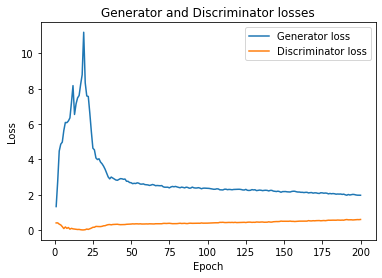

In [14]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator losses')
plt.show()

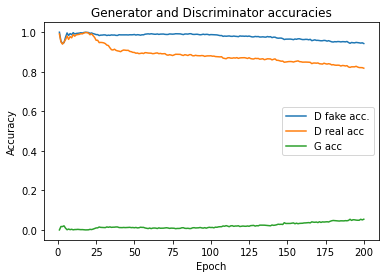

In [15]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator accuracies')
plt.show()

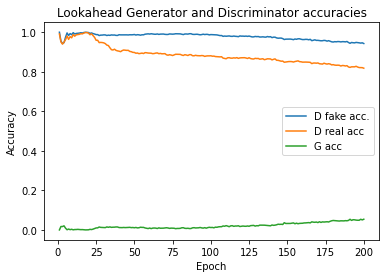

In [16]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator accuracies')
plt.show()

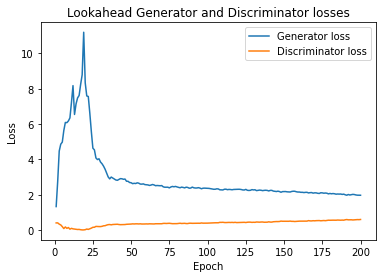

In [17]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator losses')
plt.show()

### Plot FID

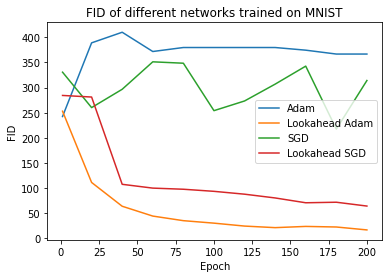

In [18]:
for k in FIDs_dic:
    plt.plot(list_epochs, FIDs_dic[k], label=k)
    
plt.ylabel('FID')
plt.xlabel('Epoch')
plt.legend()
plt.title('FID of different networks trained on MNIST')
plt.show()

In [19]:
for k in FIDs_dic:
    print('{} : {}'.format(k, min(FIDs_dic[k])))

Adam : 242.33152997938177
Lookahead Adam : 16.896503602804103
SGD : 217.31283835506662
Lookahead SGD : 64.32207516007799


# Fashion MNIST

### Load data

In [20]:
dataset_name = 'fashion_MNIST'

# load Fashion MNIST data
train_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=False, transform=transform, download=True)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Save pictures from test dataset to computer FID later
count = 0
for i, batch in enumerate(test_loader):
    for b in range(len(batch[0])):
        save_image(batch[0][b], './FID_data/test_pictures/img' + str(count) + '.png')
        count += 1
    print('Saving test pictures : {}/{}...'.format(count, len(test_loader)*bs), end='\r')

In [21]:
# save first batch as a picture
save_image(next(iter(train_loader))[0], './{}_batch1'.format(dataset_name) + '.png')

### Train and evaluate networks

In [22]:
FIDs_dic_fashion = {}

for opt_name in optimizers:
    print('Training using ' + opt_name)

    G_loss_per_epoch = []
    D_loss_per_epoch = []
    
    D_real_acc_per_epoch = []
    D_fake_acc_per_epoch = []
    G_acc_per_epoch = []
    
    FIDs_fashion = []
    list_epochs = []
    
    G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
    D = Discriminator(mnist_dim).to(device)
    
    if opt_name == 'Adam':
        lr = 0.00001
        G_optimizer = optim.Adam(G.parameters(), lr = lr)
        D_optimizer = optim.Adam(D.parameters(), lr = lr)
    elif opt_name == 'Lookahead Adam':
        lr = 0.00001
        G_optimizer = optim.Adam(G.parameters(), lr = lr)
        G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
        D_optimizer = optim.Adam(D.parameters(), lr = lr)
        D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
    elif opt_name == 'SGD':
        lr = 0.001
        G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
        D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
    elif opt_name == 'Lookahead SGD':
        lr = 0.001
        G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
        G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
        D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
        D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
    
    for epoch in range(1, n_epoch+1):
        D_losses, G_losses = [], []
        D_real_accs, D_fake_accs, G_accs = [], [], []
        
        for batch_idx, (x, _) in enumerate(train_loader):
            D_current_loss, D_batch_real_acc, D_batch_fake_acc = D_train(x)
            G_current_loss, G_batch_acc = G_train(x)
    
            D_real_accs.append(D_batch_real_acc)
            D_fake_accs.append(D_batch_fake_acc)
            G_accs.append(G_batch_acc)
    
            D_losses.append(D_current_loss)
            G_losses.append(G_current_loss)
    
        G_loss = torch.mean(torch.FloatTensor(G_losses))
        D_loss = torch.mean(torch.FloatTensor(D_losses))
    
        G_loss_per_epoch.append(G_loss.item())
        D_loss_per_epoch.append(D_loss.item())
    
        D_real_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_real_accs)).item())
        D_fake_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_fake_accs)).item())
        G_acc_per_epoch.append(torch.mean(torch.FloatTensor(G_accs)).item())
        
        print('[%d/%d]: loss_d: %.7f, loss_g: %.3f' % ((epoch), n_epoch, D_loss, G_loss)) 
        
        count = 0
        if epoch == 1 or epoch%20 == 0 or epoch == n_epoch: # every n epochs and after last epoch
            
            # save pictures generated with generator and compute current FID
            for i in range(int(G_set_size/bs)):
                G_seeds = torch.randn(bs, z_dim).to(device)
                G_pictures = G(G_seeds)
                G_pictures = G_pictures.view(G_pictures.size(0), 1, 28, 28)
    
                for b in range(bs):
                    save_image(G_pictures[b], './FID_data/generated_pictures/img' + str(count) + '.png')
                    count += 1
                print('Generating pictures : {}/{}...'.format(count, G_set_size), end='\r')
                
            print()
            print('Computing FID...', end='\r')
            fid = !python -m pytorch_fid "./FID_data/generated_pictures/" "./FID_data/test_pictures/"
            fid = float(fid[-1].replace('FID:  ', ''))
            print('FID : {}'.format(fid), end='\r')
            print()
            FIDs_fashion.append(fid) 
            list_epochs.append(epoch)
            
            # generate and save samples
            samples_per_epoch = 1
            for sample_nbr in range(1, samples_per_epoch+1):
                with torch.no_grad():
                    test_z = torch.randn(bs, z_dim).to(device)
                    generated = G(test_z)
                    save_image(generated.view(generated.size(0), 1, 28, 28), './{}_{}_epoch_{}'.format(dataset_name, opt_name, epoch) + '.png')
    
    FIDs_dic_fashion[opt_name] = FIDs_fashion

Training using Adam
[1/200]: loss_d: 1.1022094, loss_g: 0.661
Generating pictures : 10000/10000...
FID : 472.1928953280714
[2/200]: loss_d: 0.7547600, loss_g: 0.983
[3/200]: loss_d: 0.5198813, loss_g: 1.429
[4/200]: loss_d: 0.4211333, loss_g: 1.987
[5/200]: loss_d: 0.4037148, loss_g: 2.395
[6/200]: loss_d: 0.3711882, loss_g: 2.535
[7/200]: loss_d: 0.2275752, loss_g: 3.072
[8/200]: loss_d: 0.3021815, loss_g: 2.968
[9/200]: loss_d: 0.2002834, loss_g: 3.716
[10/200]: loss_d: 0.2279534, loss_g: 3.729
[11/200]: loss_d: 0.1866975, loss_g: 3.836
[12/200]: loss_d: 0.1963236, loss_g: 3.860
[13/200]: loss_d: 0.1015353, loss_g: 4.361
[14/200]: loss_d: 0.1380868, loss_g: 4.647
[15/200]: loss_d: 0.0702683, loss_g: 5.305
[16/200]: loss_d: 0.1247897, loss_g: 4.750
[17/200]: loss_d: 0.0877499, loss_g: 5.469
[18/200]: loss_d: 0.1379792, loss_g: 4.888
[19/200]: loss_d: 0.0815783, loss_g: 5.297
[20/200]: loss_d: 0.1158597, loss_g: 5.000
Generating pictures : 10000/10000...
FID : 317.25518049481605
[21/20

[177/200]: loss_d: 1.2338357, loss_g: 0.911
[178/200]: loss_d: 1.2150099, loss_g: 0.923
[179/200]: loss_d: 1.2096192, loss_g: 0.928
[180/200]: loss_d: 1.2057513, loss_g: 0.931
Generating pictures : 10000/10000...
FID : 98.93694417235065
[181/200]: loss_d: 1.2146614, loss_g: 0.923
[182/200]: loss_d: 1.2198355, loss_g: 0.929
[183/200]: loss_d: 1.2286417, loss_g: 0.912
[184/200]: loss_d: 1.2110674, loss_g: 0.927
[185/200]: loss_d: 1.2097812, loss_g: 0.933
[186/200]: loss_d: 1.2141222, loss_g: 0.922
[187/200]: loss_d: 1.2290609, loss_g: 0.909
[188/200]: loss_d: 1.2176704, loss_g: 0.919
[189/200]: loss_d: 1.2230902, loss_g: 0.923
[190/200]: loss_d: 1.2251709, loss_g: 0.917
[191/200]: loss_d: 1.2043995, loss_g: 0.928
[192/200]: loss_d: 1.2185824, loss_g: 0.927
[193/200]: loss_d: 1.2176247, loss_g: 0.926
[194/200]: loss_d: 1.2249293, loss_g: 0.913
[195/200]: loss_d: 1.2205943, loss_g: 0.907
[196/200]: loss_d: 1.2248210, loss_g: 0.911
[197/200]: loss_d: 1.2335699, loss_g: 0.900
[198/200]: loss

[151/200]: loss_d: 1.1787362, loss_g: 0.960
[152/200]: loss_d: 1.1716509, loss_g: 0.962
[153/200]: loss_d: 1.1744269, loss_g: 0.955
[154/200]: loss_d: 1.1513183, loss_g: 0.979
[155/200]: loss_d: 1.1914021, loss_g: 0.963
[156/200]: loss_d: 1.1728276, loss_g: 0.956
[157/200]: loss_d: 1.1906064, loss_g: 0.950
[158/200]: loss_d: 1.1834360, loss_g: 0.953
[159/200]: loss_d: 1.1746163, loss_g: 0.957
[160/200]: loss_d: 1.1813804, loss_g: 0.957
Generating pictures : 10000/10000...
FID : 124.40148906813431
[161/200]: loss_d: 1.1915792, loss_g: 0.951
[162/200]: loss_d: 1.2101351, loss_g: 0.928
[163/200]: loss_d: 1.1910006, loss_g: 0.940
[164/200]: loss_d: 1.1819929, loss_g: 0.957
[165/200]: loss_d: 1.1965332, loss_g: 0.950
[166/200]: loss_d: 1.1873289, loss_g: 0.935
[167/200]: loss_d: 1.1851557, loss_g: 0.949
[168/200]: loss_d: 1.1983007, loss_g: 0.957
[169/200]: loss_d: 1.1812408, loss_g: 0.948
[170/200]: loss_d: 1.1990978, loss_g: 0.948
[171/200]: loss_d: 1.1833805, loss_g: 0.958
[172/200]: los

[126/200]: loss_d: 0.8426074, loss_g: 1.601
[127/200]: loss_d: 0.8575871, loss_g: 1.576
[128/200]: loss_d: 0.8424711, loss_g: 1.566
[129/200]: loss_d: 0.8483541, loss_g: 1.601
[130/200]: loss_d: 0.8495657, loss_g: 1.579
[131/200]: loss_d: 0.8459166, loss_g: 1.589
[132/200]: loss_d: 0.8562074, loss_g: 1.585
[133/200]: loss_d: 0.8594887, loss_g: 1.561
[134/200]: loss_d: 0.8500366, loss_g: 1.584
[135/200]: loss_d: 0.8511392, loss_g: 1.586
[136/200]: loss_d: 0.8477851, loss_g: 1.586
[137/200]: loss_d: 0.8735773, loss_g: 1.536
[138/200]: loss_d: 0.8593084, loss_g: 1.555
[139/200]: loss_d: 0.8618848, loss_g: 1.568
[140/200]: loss_d: 0.8546061, loss_g: 1.561
Generating pictures : 10000/10000...
FID : 97.66807350219909
[141/200]: loss_d: 0.8568223, loss_g: 1.560
[142/200]: loss_d: 0.8716637, loss_g: 1.560
[143/200]: loss_d: 0.8661175, loss_g: 1.540
[144/200]: loss_d: 0.8735966, loss_g: 1.517
[145/200]: loss_d: 0.8839502, loss_g: 1.504
[146/200]: loss_d: 0.8770316, loss_g: 1.516
[147/200]: loss

Generating pictures : 10000/10000...
FID : 102.76948286095927
[101/200]: loss_d: 0.7905480, loss_g: 1.729
[102/200]: loss_d: 0.8130774, loss_g: 1.692
[103/200]: loss_d: 0.8008974, loss_g: 1.717
[104/200]: loss_d: 0.8101994, loss_g: 1.689
[105/200]: loss_d: 0.7967899, loss_g: 1.722
[106/200]: loss_d: 0.8242818, loss_g: 1.662
[107/200]: loss_d: 0.8092945, loss_g: 1.689
[108/200]: loss_d: 0.8186322, loss_g: 1.668
[109/200]: loss_d: 0.8153884, loss_g: 1.687
[110/200]: loss_d: 0.8204356, loss_g: 1.664
[111/200]: loss_d: 0.8259449, loss_g: 1.660
[112/200]: loss_d: 0.8356630, loss_g: 1.646
[113/200]: loss_d: 0.8401192, loss_g: 1.607
[114/200]: loss_d: 0.8388154, loss_g: 1.626
[115/200]: loss_d: 0.8462675, loss_g: 1.590
[116/200]: loss_d: 0.8471926, loss_g: 1.608
[117/200]: loss_d: 0.8499941, loss_g: 1.608
[118/200]: loss_d: 0.8540585, loss_g: 1.595
[119/200]: loss_d: 0.8512093, loss_g: 1.579
[120/200]: loss_d: 0.8600144, loss_g: 1.599
Generating pictures : 10000/10000...
FID : 101.54704764722

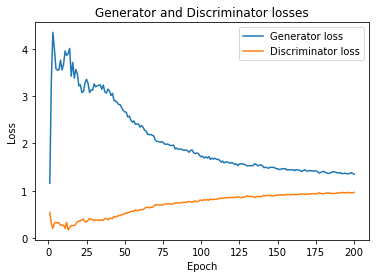

In [23]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator losses')
plt.show()

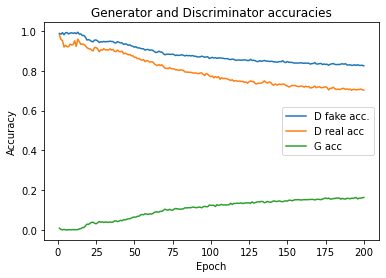

In [24]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator accuracies')
plt.show()

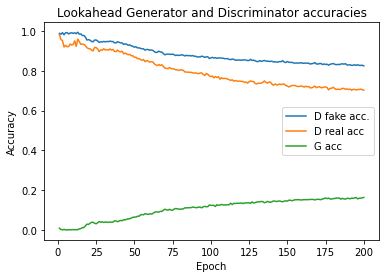

In [25]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator accuracies')
plt.show()

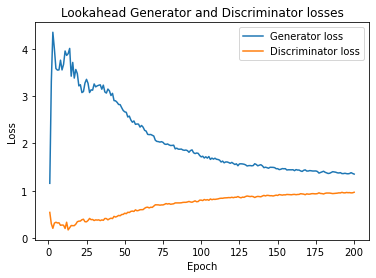

In [26]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator losses')
plt.show()

### Plot FID

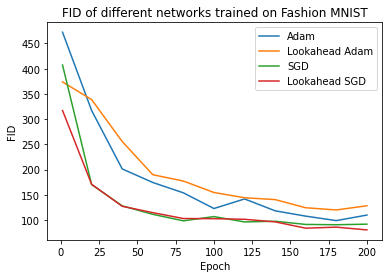

In [27]:
for k in FIDs_dic_fashion:
    plt.plot(list_epochs, FIDs_dic_fashion[k], label=k)
    
plt.ylabel('FID')
plt.xlabel('Epoch')
plt.legend()
plt.title('FID of different networks trained on Fashion MNIST')
plt.show()

In [28]:
for k in FIDs_dic_fashion:
    print('{} : {}'.format(k, min(FIDs_dic_fashion[k])))

Adam : 98.93694417235065
Lookahead Adam : 120.02517340196107
SGD : 90.76592165171729
Lookahead SGD : 80.48571134107365
